In [67]:
# imports
import numpy as np

import sys as sys
import os
import tkinter as tk
from tkinter import filedialog

import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plb

from skimage import io
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import exp

import time


In [3]:
# options
zsave = False

In [4]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [6]:
root = tk.Tk()
root.withdraw()

directory = filedialog.askdirectory(title = 'choose folder with STICS data set format:.csv' ) 
os.chdir(directory)

In [16]:
# metadata
x_pixel_size = 0.116  # um
y_pixel_size = 0.116  # um
avg_delta_t = 11.58124  # ms - get this by running the appropriate code on the corresponding metadata!

num_px_x = 90
num_px_y = 108
max_cycle_length = 5


In [49]:
# initialize
image_stack = np.empty(shape=(num_px_y,num_px_x))
#print(image_stack.shape)

period_map = np.empty(shape=(num_px_y,num_px_x))
frequency_map = np.empty(shape=(num_px_y,num_px_x))


In [50]:
def zslice_identifier(x):
    return(x[-11:-6])

In [51]:
num_files = 0
all_files = os.listdir(directory)

for filename in sorted(all_files, key = zslice_identifier):
    print(filename)

    if filename.endswith(".tif"):
        num_files += 1
        temp_img = io.imread(filename)
        
        #imgplot = plt.imshow(temp_img)
        #plt.show()
        
        #check image properties
        image_size = temp_img.shape
        bit_depth = temp_img.dtype
        
        image_stack=np.dstack((image_stack, temp_img))
        
if num_files != max_cycle_length:
    print("Verify input metadata!")
    
print(image_stack.shape)

Pos0_STICS_map.tifPos0_STICS_map_c00_z0000_t0000.tif
Pos0_STICS_map.tifPos0_STICS_map_c00_z0001_t0000.tif
Pos0_STICS_map.tifPos0_STICS_map_c00_z0002_t0000.tif
Pos0_STICS_map.tifPos0_STICS_map_c00_z0003_t0000.tif
Pos0_STICS_map.tifPos0_STICS_map_c00_z0004_t0000.tif
(108, 90, 6)


In [52]:
def gaussian(x, offset, amp, x0, sigma):
    return offset + amp * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gaussian_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gaussian, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [56]:
for i in range(0,num_px_x):
    for j in range(0,num_px_y):
        delta_t = []
        correlation = []
        for k in range(0,max_cycle_length):
            delta_t.append(k)
            correlation.append(image_stack[j,i,k])
            
            #print(delta_t)
            #print(correlation)
            
            if k == max_cycle_length-1:
                
                delta_t = np.array(delta_t)
                correlation = np.array(correlation)
                local_min_ind = argrelextrema(correlation,np.less)

                if len(local_min_ind) > 1:
                    x = delta_t[local_min_ind[0]:local_min_ind[1]]
                    y = correlation[local_min_ind[0]:local_min_ind[1]]
                    
                    #mean is cycle duration of one period in frames as it gives you the first peak after delta_t=0 (image correlated with itself) and hence how long it takes to look most like the original image again
                    popt = gaussian_fit(x,y)
                    #popt is parameters of gaussian: popt[0] is offset, popt[1] is amplitude, popt[2] is mean, popt[3] is sigma
                
                    period = popt[2] # in frames
                    frequency = 1/(period*(avg_delta_t/1000)) # converted to Hz
                    
                    period_map[j,i] = period
                    frequency_map[j,i] = frequency


In [73]:
#for testing

x = np.array([0,1,2,3,4])
y = np.array([-0.2,0.1,0.6,0.3,-0.01])

#mean is cycle duration of one period in frames as it gives you the first peak after delta_t=0 (image correlated with itself) and hence how long it takes to look most like the original image again
popt = gaussian_fit(x,y)

print(popt)

frequency_map = [[1,1,1,1,1,1,1],[1,3,5,5,5,5,5],[2,3,5,5,5,5,5],[2,3,5,5,5,5,5],[2,3,5,5,5,5,5],[5,5,5,5,5,5,5]]

[-0.2         0.6         2.73417722         nan]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [74]:
#maybe filter out really short frequencies - background?

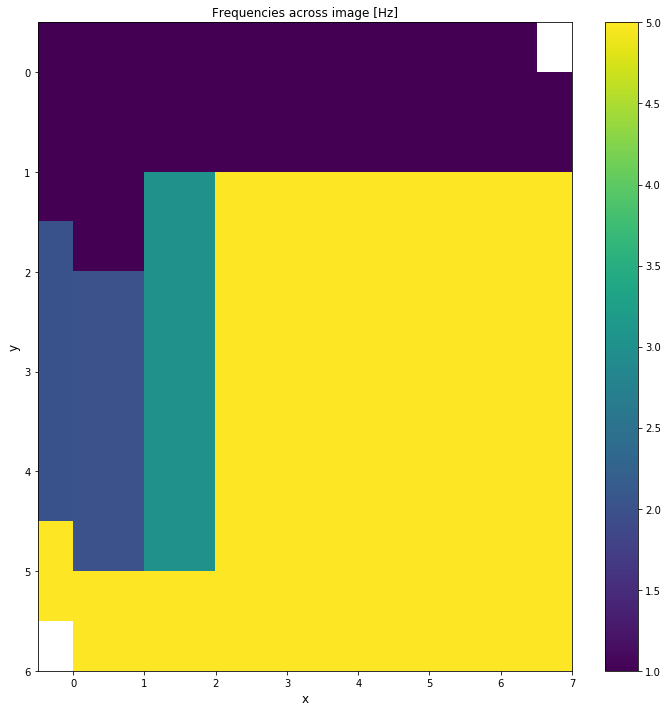

In [75]:
%matplotlib inline

#plot of frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

color_lim = (np.amin(frequency_map),np.amax(frequency_map))

ax.imshow(frequency_map, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
ax.set_title("Frequencies across image [Hz]", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_xlabel("x", fontsize=12)
pcm = ax.pcolormesh(frequency_map,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax)

plt.tight_layout()

# save fig
if zsave == True:
    #script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(directory, 'Results/')
    file_name = 'Frequency_map_{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name,dpi=130)

plt.show()

In [ ]:
# Save our multicolour stack to a new ImageJ-compatible TIF file
# tifffile wants our array to be in TZCYXS order for imageJ compatibility

io.imsave('./assets/bbbc034v1/AICS_12_134_C=all.tif',
          np.moveaxis(my4DArray,-1,1),
          imagej=True,
          resolution=(1/x_pixel_size,1/y_pixel_size),
          metadata={'spacing':z_pixel_size,'unit':'nm'})